# ScopeSim on a sub-pixel level

In this notebook, we will load the model of MICADO (including Armazones, ELT, MAORY) and then turn off all effect that modify the spatial extent of the stars. The purpose here is to see in detail what happens to the **distribution of the stars flux on a sub-pixel level** when we add plug-in astrometric Effect to the optical system.

For real simulation, we will obviously leave all normal MICADO effects turned on, while still adding plug-in Effect. Hopefully this Notebok will serve as a refernce for those who want to see **how to create Plug-ins** and how to manipulate the effects in the MICADO optical train model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import scopesim as sim
from scopesim_templates.basic import stars

In [2]:
# Run these if you are using scopesim and the MICADO package for the first time
sim.rc.__config__["!SIM.file.use_cached_downloads"] = False

sim.list_packages()
sim.download_package(["locations/Armazones", "telescopes/ELT", "instruments/MICADO", "instruments/MAORY"])


Packages saved on the server: https://www.univie.ac.at/simcado/InstPkgSvr/
instruments/HAWKI.zip
instruments/MAORY.zip
instruments/MICADO.zip
instruments/WFC3.zip
instruments/test_package.zip
locations/Armazones.zip
locations/Paranal.zip
telescopes/ELT.zip
telescopes/HST.zip
telescopes/LFOA.zip
telescopes/VLT.zip

Packages saved locally: ./


['C:\\Work\\ScopeSim\\docs\\source\\_static\\Armazones.zip',
 'C:\\Work\\ScopeSim\\docs\\source\\_static\\ELT.zip',
 'C:\\Work\\ScopeSim\\docs\\source\\_static\\MICADO.zip',
 'C:\\Work\\ScopeSim\\docs\\source\\_static\\MAORY.zip']

## Make MICADO and turn everything off

In [3]:
cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["SCAO", "IMG_1.5mas"])
micado = sim.OpticalTrain(cmd)

Preparing 13 FieldOfViews


In [4]:
micado["detector_window"].include = True
for effect_name in ["full_detector_array", "armazones_atmo_dispersion", "micado_adc_3D_shift", "micado_ncpas_psf", "relay_psf"]:
    micado[effect_name].include = False
    print(micado[effect_name])

micado.effects   # print a table of all the Effect objects that exist in micado

DetectorList: "full_detector_array"
AtmosphericDispersion: "armazones_atmo_dispersion"
AtmosphericDispersionCorrection: "micado_adc_3D_shift"
NonCommonPathAberration: "micado_ncpas_psf"
FieldConstantPSF: "relay_psf"


element,name,class,included,z_orders
str21,str32,str31,bool,object
armazones,armazones_atmo_default_ter_curve,AtmosphericTERCurve,True,[111]
armazones,armazones_atmo_dispersion,AtmosphericDispersion,False,[231]
armazones,armazones_atmo_skycalc_ter_curve,SkycalcTERCurve,False,[112]
ELT,scope_surface_list,SurfaceList,True,"[20, 120]"
ELT,scope_vibration,Vibration,True,"[244, 744]"
ELT,eso_combined_reflection,TERCurve,False,"[10, 110]"
MICADO,micado_static_surfaces,SurfaceList,True,"[20, 120]"
MICADO,micado_filter,FilterCurve,True,"[114, 214]"
MICADO,micado_ncpas_psf,NonCommonPathAberration,False,"[241, 641]"


## Resize the detector window and set some other settings

In [5]:
micado["detector_window"].data["x_cen"] = 0          # [mm] distance from optical axis on the focal plane
micado["detector_window"].data["y_cen"] = 0
micado["detector_window"].data["xhw"] = 0.015 * 5.5  # [mm] x "half-width"
micado["detector_window"].data["yhw"] = 0.015 * 5.5

micado.cmds["!OBS.dit"] = 60                         # [s]
micado.cmds["!OBS.ndit"] = 1
micado.cmds["!SIM.sub_pixel.flag"] = True

## Make a grid of sources

In [6]:
src = stars.star_grid(n=9, mmin=20, mmax=20.0001, separation=0.0015 * 3)
src.fields[0]["x"] -= 0.00075
src.fields[0]["y"] -= 0.00075

## Observe the grid of stars

In [7]:
micado.observe(src, update=True)

Preparing 1 FieldOfViews


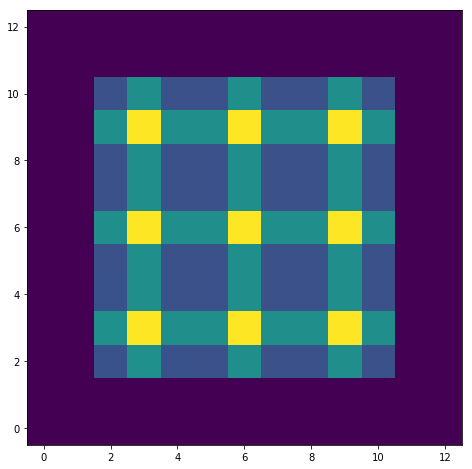

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(micado.image_planes[0].data, origin="lower")

## Write a new Effect subclass "PointSourceJitter"

In [9]:
import numpy as np
from astropy.table import Table

from scopesim.effects import Effect
from scopesim.base_classes import SourceBase


class PointSourceJitter(Effect):
    def __init__(self, **kwargs):
        super(PointSourceJitter, self).__init__(**kwargs)   # initialise the underlying Effect class object
        self.meta["z_order"] = [500]                        # z_order number for knowing when and how to apply the Effect
        self.meta["max_jitter"] = 0.001                     # [arcsec] - a parameter needed by the effect
        self.meta.update(kwargs)                            # add any extra parameters passed when initialising
    
    def apply_to(self, obj):                                # the function that does the work 
        if isinstance(obj, SourceBase):                 
            for field in obj.fields:
                if isinstance(field, Table):
                    dx, dy = 2 * (np.random.random(size=(2, len(field))) - 0.5)
                    field["x"] += dx * self.meta["max_jitter"]
                    field["y"] += dy * self.meta["max_jitter"]
                    
        return obj
    

## Make an instance of the new Effect and add it to MICADO

In [10]:
jitter_effect = PointSourceJitter(max_jitter=0.001, name="random_jitter")
micado.optics_manager.add_effect(jitter_effect)

In [11]:
micado.effects

element,name,class,included,z_orders
str21,str32,str31,bool,object
armazones,armazones_atmo_default_ter_curve,AtmosphericTERCurve,True,[111]
armazones,armazones_atmo_dispersion,AtmosphericDispersion,False,[231]
armazones,armazones_atmo_skycalc_ter_curve,SkycalcTERCurve,False,[112]
armazones,random_jitter,PointSourceJitter,True,[500]
ELT,scope_surface_list,SurfaceList,True,"[20, 120]"
ELT,scope_vibration,Vibration,True,"[244, 744]"
ELT,eso_combined_reflection,TERCurve,False,"[10, 110]"
MICADO,micado_static_surfaces,SurfaceList,True,"[20, 120]"
MICADO,micado_filter,FilterCurve,True,"[114, 214]"


## Observe the star grid again (this time applying the extra Effect object)

In [12]:
micado.observe(src, update=True)

Preparing 1 FieldOfViews


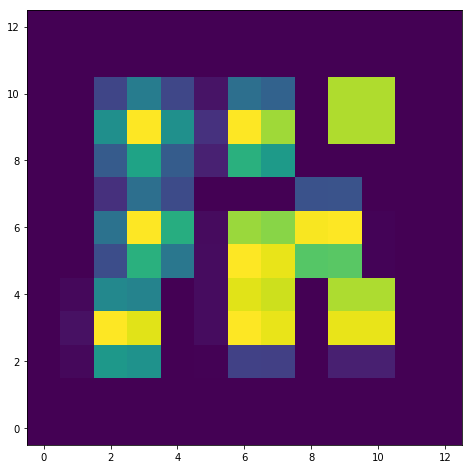

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(micado.image_planes[0].data, origin="lower")

## We can change the amount of jitter involved

Preparing 1 FieldOfViews


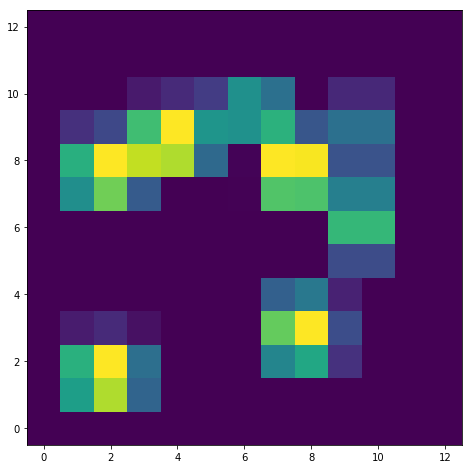

In [14]:
micado["random_jitter"].meta["max_jitter"] = 0.003

micado.observe(src, update=True)

plt.figure(figsize=(8,8))
plt.imshow(micado.image_planes[0].data, origin="lower")